<a href="https://colab.research.google.com/github/pkky/Projekty/blob/main/Projekt2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import os
import warnings

In [2]:
from keras.optimizers import SGD
from keras.datasets import cifar10

from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D, MaxPooling2D

from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K

In [3]:
from os import listdir, makedirs
from os.path import join, exists, expanduser

cache_dir = expanduser(join('~', '.keras'))
if not exists(cache_dir):
    makedirs(cache_dir)
datasets_dir = join(cache_dir, 'datasets')
if not exists(datasets_dir):
    makedirs(datasets_dir)


!cp ../input/cifar-10-python.tar.gz ~/.keras/datasets/
!ln -s  ~/.keras/datasets/cifar-10-python.tar.gz ~/.keras/datasets/cifar-10-batches-py.tar.gz
!tar xzvf ~/.keras/datasets/cifar-10-python.tar.gz -C ~/.keras/datasets/

cp: cannot stat '../input/cifar-10-python.tar.gz': No such file or directory
ln: failed to create symbolic link '/root/.keras/datasets/cifar-10-batches-py.tar.gz': File exists
cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


In [4]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
print("CIFAR-10 dataset loaded...")

CIFAR-10 dataset loaded...


In [5]:
def add_side(images, side_type, side_size=1):
        new_images=list()
        for image in images:
        
            if side_type=="horizantal":
                side=np.ones((image.shape[0],side_size,image.ndim), dtype=image.dtype)*255
                image=np.hstack((image,side))
            elif side_type=="vertical":#vertical
                side=np.ones((side_size,image.shape[1],image.ndim), dtype=image.dtype)*255
                image=np.vstack((image,side))
            
            new_images.append(image)
        return new_images

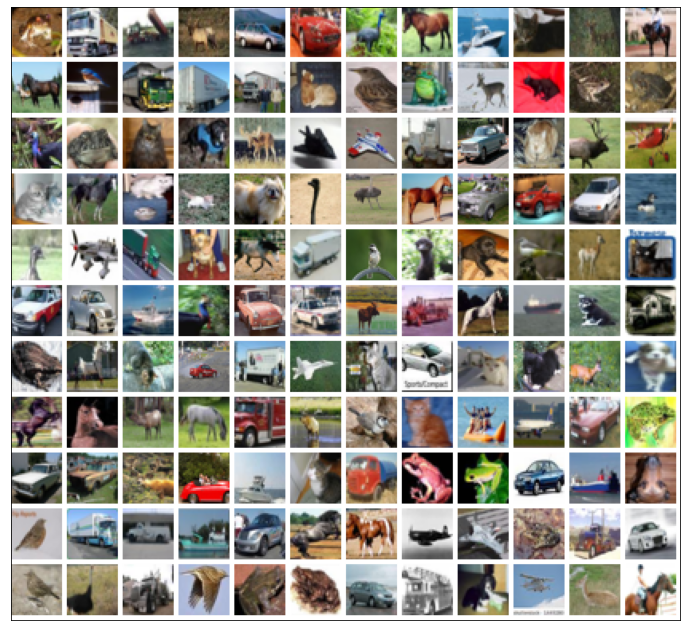

In [6]:
rows=list()
step=12
for i in range(0, 130, step):
    horizantal_sided_images=add_side(X_train[i:i+step], side_type="horizantal", side_size=3)
    row=np.hstack((horizantal_sided_images))
    
    rows.append(row)

vertical_sided_images=add_side(rows, side_type="vertical",side_size=3)
gallery=np.vstack((vertical_sided_images))
plt.figure(figsize=(12,12))
plt.imshow(gallery)
plt.xticks([])
plt.yticks([])
plt.show()

In [7]:
class VGGNet():
    @staticmethod
    def build(width, height, depth, classes):
        model = Sequential([
        Conv2D(64, (3, 3), input_shape=(width,height,depth), padding='same',
               activation='relu'),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(axis=-1),
        MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        Conv2D(128, (3, 3), activation='relu', padding='same',),
        BatchNormalization(axis=-1),
        MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
        Conv2D(256, (3, 3), activation='relu', padding='same',),
        Conv2D(256, (3, 3), activation='relu', padding='same',),
        Conv2D(256, (3, 3), activation='relu', padding='same',),
        BatchNormalization(axis=-1),
        MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
        Conv2D(512, (3, 3), activation='relu', padding='same',),
        Conv2D(512, (3, 3), activation='relu', padding='same',),
        Conv2D(512, (3, 3), activation='relu', padding='same',),
        BatchNormalization(axis=-1),
        MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
        Conv2D(512, (3, 3), activation='relu', padding='same',),
        Conv2D(512, (3, 3), activation='relu', padding='same',),
        Conv2D(512, (3, 3), activation='relu', padding='same',),
        BatchNormalization(axis=-1),
        MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
        Flatten(),
        Dense(4096, activation='relu'),
        Dense(4096, activation='relu'),
        Dense(classes, activation='softmax')
        ])
        return model

In [8]:
class MiniVGGNet():
    @staticmethod
    def build(width, height, depth, classes):
        model=Sequential()
        #=============== First Convolutional Layer ========================
        model.add(Conv2D(32, (3,3), padding="same",input_shape=(width,height,depth)))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=-1))
        
        model.add(Conv2D(32, (3,3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=-1))
                  
        model.add(MaxPooling2D(pool_size=(2,2)))
        model.add(Dropout(0.25))
        
        #=============== Second Convolutional Layer ========================        
        model.add(Conv2D(64, (3,3), padding="same"))
        model.add(Activation('relu'))
        model.add(BatchNormalization(axis=-1))
        
        model.add(Conv2D(64, (3,3), padding="same"))
        model.add(Activation('relu'))
        model.add(BatchNormalization(axis=-1))
        
        model.add(MaxPooling2D(pool_size=(2,2)))
        model.add(Dropout(0.25))
        
        #================ First Fully Connected Layer =====================
        model.add(Flatten())
        model.add(Dense(512))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))
        
                  
        #================ Soft Classifier ================================
        model.add(Dense(classes))
        model.add(Activation('softmax'))
        
    
        return model     

In [9]:
def show_model_history(modelHistory, model_name):
    history=pd.DataFrame()
    history["Train Loss"]=modelHistory.history['loss']
    history["Validation Loss"]=modelHistory.history['val_loss']
    history["Train Accuracy"]=modelHistory.history['accuracy']
    history["Validation Accuracy"]=modelHistory.history['val_accuracy']
    
    fig, axarr=plt.subplots(nrows=2, ncols=1 ,figsize=(12,8))
    axarr[0].set_title("History of Loss in Train and Validation Datasets")
    history[["Train Loss", "Validation Loss"]].plot(ax=axarr[0])
    axarr[1].set_title("History of Accuracy in Train and Validation Datasets")
    history[["Train Accuracy", "Validation Accuracy"]].plot(ax=axarr[1]) 
    plt.suptitle(" Convulutional Model {} Loss and Accuracy in Train and Validation Datasets".format(model_name))
    plt.show()

In [10]:
X_train =X_train.astype(np.float32)/255.0
X_test= X_test.astype(np.float32)/255.0
print("Przeprowadzono normalizację...")

Przeprowadzono normalizację...


In [11]:
print("y_train.shape:",y_train.shape)
print("y_train[0]:",y_train[0])

y_train.shape: (50000, 1)
y_train[0]: [6]


In [12]:
labelBinarizer=LabelBinarizer()
y_train=labelBinarizer.fit_transform(y_train)
y_test=labelBinarizer.transform(y_test)
print("Kodowanie OneHot przeprowadzono dla sieci...")

Kodowanie OneHot przeprowadzono dla sieci...


In [13]:
print("y_train.shape:",y_train.shape)
print("y_train[0]:",y_train[0])

y_train.shape: (50000, 10)
y_train[0]: [0 0 0 0 0 0 1 0 0 0]


In [14]:
print(K.image_data_format())

channels_last


In [15]:
VGGNet_type="normal"
if VGGNet_type=="normal":
    print("Normal VGGNet modeli seçildi...")
    model=VGGNet.build(width=32, height=32, depth=3, classes=10)
else:
    print("Mini VGGNet modeli seçildi...")
    model = MiniVGGNet.build(width=32, height=32, depth=3, classes=10)

Normal VGGNet modeli seçildi...


In [16]:
opt = SGD(lr=0.01, decay=0.01 / 40, momentum=0.9, nesterov=True)
model.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy"])
print("Model jest skomplikowany...")

Model jest skomplikowany...


In [17]:
modelHistory = model.fit(X_train, y_train, 
                         validation_data=(X_test, y_test),
                         batch_size=64, 
                         epochs=40)

Epoch 1/40
782/782 [==============================] - 37s 43ms/step - loss: 1.7634 - accuracy: 0.3619 - val_loss: 1.5828 - val_accuracy: 0.4514
Epoch 2/40
782/782 [==============================] - 33s 43ms/step - loss: 1.0137 - accuracy: 0.6384 - val_loss: 1.4021 - val_accuracy: 0.5648
Epoch 3/40
782/782 [==============================] - 34s 43ms/step - loss: 0.7183 - accuracy: 0.7520 - val_loss: 0.8815 - val_accuracy: 0.7011
Epoch 4/40
782/782 [==============================] - 34s 43ms/step - loss: 0.5408 - accuracy: 0.8148 - val_loss: 0.7671 - val_accuracy: 0.7453
Epoch 5/40
782/782 [==============================] - 34s 43ms/step - loss: 0.3991 - accuracy: 0.8626 - val_loss: 0.6811 - val_accuracy: 0.7759
Epoch 6/40
782/782 [==============================] - 34s 43ms/step - loss: 0.2799 - accuracy: 0.9025 - val_loss: 0.9188 - val_accuracy: 0.7260
Epoch 7/40
782/782 [==============================] - 34s 43ms/step - loss: 0.2048 - accuracy: 0.9301 - val_loss: 0.7934 - val_accuracy:

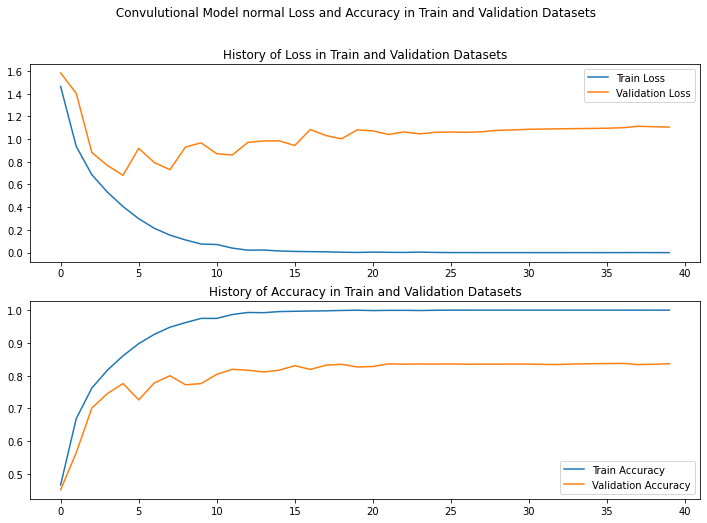

In [18]:
show_model_history(modelHistory=modelHistory, model_name=VGGNet_type)

In [19]:
predictions = model.predict(X_test, batch_size=256)

In [20]:
acc_score=accuracy_score(y_test.argmax(axis=1),predictions.argmax(axis=1))
print("Accuracy score:",acc_score)

class_names=["airplane", "automobile", "bird", "cat", "deer","dog", "frog", "horse", "ship", "truck"]
print("Confusion Matrix:\n")
cm=confusion_matrix(y_test.argmax(axis=1), predictions.argmax(axis=1))
print(cm)
print("Classification Report:\n")
cr=classification_report(y_test.argmax(axis=1),
                            predictions.argmax(axis=1), 
                            target_names=class_names)
print(cr)

Accuracy score: 0.8363
Confusion Matrix:

[[879   9  28  16  14   2   6   5  27  14]
 [ 11 907   1   3   1   5   6   1  21  44]
 [ 41   1 778  32  50  43  31  13   7   4]
 [ 23   4  50 680  39 124  39  23  10   8]
 [ 11   2  40  43 822  23  30  25   3   1]
 [ 13   3  32 139  29 737  13  32   1   1]
 [  3   5  38  39  19  10 874   2   8   2]
 [  9   1  20  36  37  26   0 866   1   4]
 [ 45   5   5   2   1   3   5   2 920  12]
 [ 16  42   5   8   2   3   4   7  13 900]]
Classification Report:

              precision    recall  f1-score   support

    airplane       0.84      0.88      0.86      1000
  automobile       0.93      0.91      0.92      1000
        bird       0.78      0.78      0.78      1000
         cat       0.68      0.68      0.68      1000
        deer       0.81      0.82      0.82      1000
         dog       0.76      0.74      0.75      1000
        frog       0.87      0.87      0.87      1000
       horse       0.89      0.87      0.88      1000
        ship    

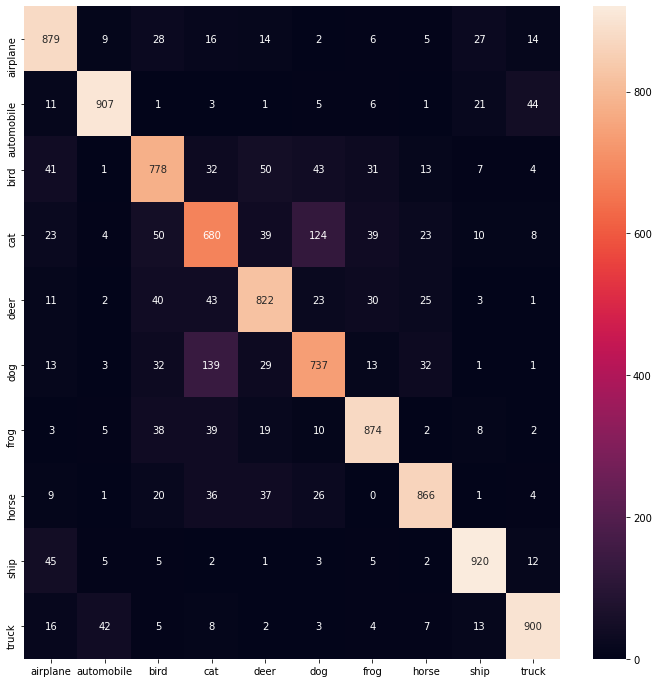

In [21]:
plt.figure(figsize=(12,12))
sns.heatmap(cm, annot=True,
           xticklabels=["airplane", "automobile", "bird", "cat", "deer",
                        "dog", "frog", "horse", "ship", "truck"],
            yticklabels=["airplane", "automobile", "bird", "cat", "deer",
                         "dog", "frog", "horse", "ship", "truck"],
            fmt="d"
           )

In [22]:
history=pd.DataFrame()

In [23]:
history["Train Loss"]=modelHistory.history['loss']
history["Validation Loss"]=modelHistory.history['val_loss']
history["Train Accuracy"]=modelHistory.history['accuracy']
history["Validation Accuracy"]=modelHistory.history['val_accuracy']

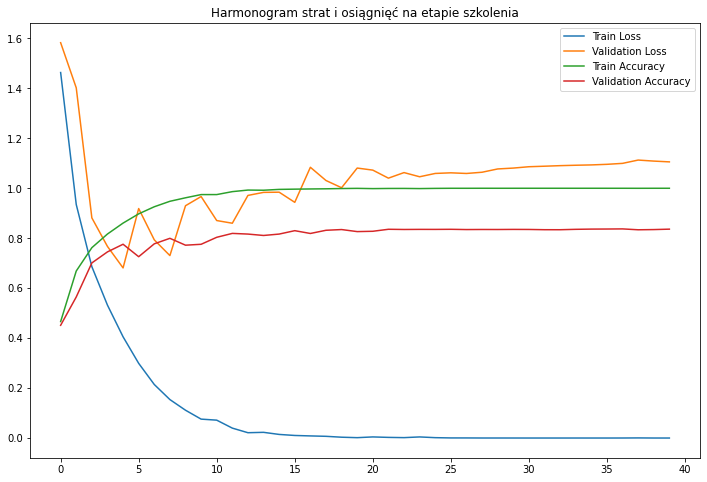

In [24]:
history.plot(figsize=(12,8))
plt.title("Harmonogram strat i osiągnięć na etapie szkolenia")
plt.show()